In [55]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load the datasets
train_path = '../datasets/scenario-1/mme_train.csv'
test_path = '../datasets/scenario-1/mme_test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


In [56]:

# Visualize each column
import matplotlib.pyplot as plt

def visualize_data(vis_data):
    """
    Visualizes the input DataFrame by plotting each column as a time series.
    If an anomaly column is present, it colors the points blue if anomaly = 0 and red if anomaly = 1.

    Parameters:
        vis_data (pd.DataFrame): The input DataFrame to be visualized.
    """
    anomaly_columns = [col for col in vis_data.columns if 'anomaly' in col]

    # Plot each column
    for column in vis_data.columns:
        print(column)
        if column not in anomaly_columns:
            plt.figure(figsize=(10, 6))
            if anomaly_columns:
                anomalies = vis_data[anomaly_columns].any(axis=1)
                plt.plot(vis_data[column], color='blue', label=column)
                plt.scatter(vis_data.index, vis_data[column], c=anomalies.map({False: 'blue', True: 'red'}), label='Anomaly')
            else:
                plt.plot(vis_data[column], label=column)
            plt.title(column)
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.show()        


In [57]:

# Select relevant columns
relevant_columns = [
'cells_1_counters_messages_nr_rrc_reconfiguration',
'cells_1_counters_messages_nr_rrc_reconfiguration_complete',
'cells_1_counters_messages_nr_rrc_ul_information_transfer',
'cells_1_drb_count_avg',
'cells_1_drb_count_max',
'cells_1_drb_count_min',
'counters_messages_ng_pdu_session_resource_release_command',
'counters_messages_ng_pdu_session_resource_release_response',
'counters_messages_ng_pdu_session_resource_setup_request',
'counters_messages_ng_pdu_session_resource_setup_response',
'counters_messages_ng_uplink_nas_transport',
]

train_df = train_data[relevant_columns]
test_df = test_data[relevant_columns]

# Δrop non numeric columns
train_df = train_df.select_dtypes(include=[np.number])
test_df = test_df.select_dtypes(include=[np.number])

# Fill NA with the last seen values
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')

# # Transform to float
train_df = train_df.astype(float)
test_df = test_df.astype(float)

# Calculate the difference between consecutive rows for each metric
train_df = train_df.diff().add_suffix('_diff')
test_df = test_df.diff().add_suffix('_diff')

# Drop the first row which will have NaN values after differencing
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Scaling the data
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)


/tmp/ipykernel_28683/309197633.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df = train_df.fillna(method='ffill')
/tmp/ipykernel_28683/309197633.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df = test_df.fillna(method='ffill')


cells_1_counters_messages_nr_rrc_reconfiguration_diff


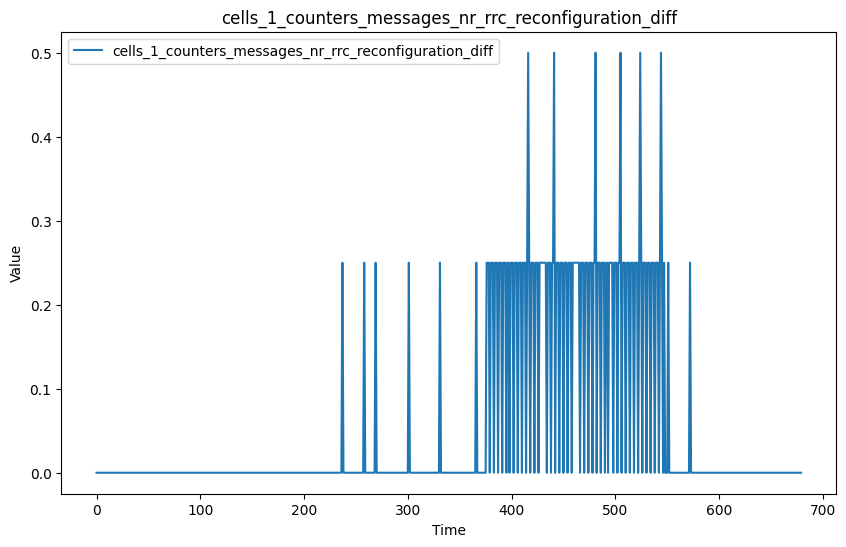

cells_1_counters_messages_nr_rrc_reconfiguration_complete_diff


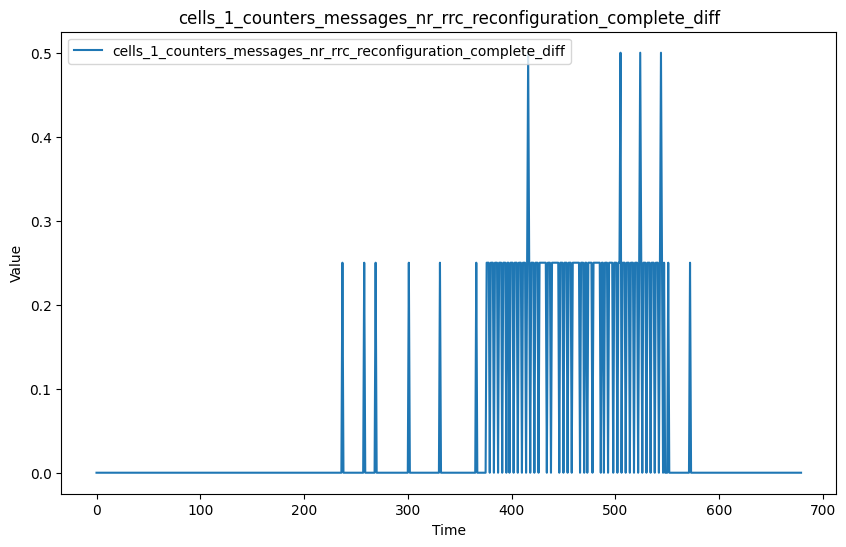

cells_1_counters_messages_nr_rrc_ul_information_transfer_diff


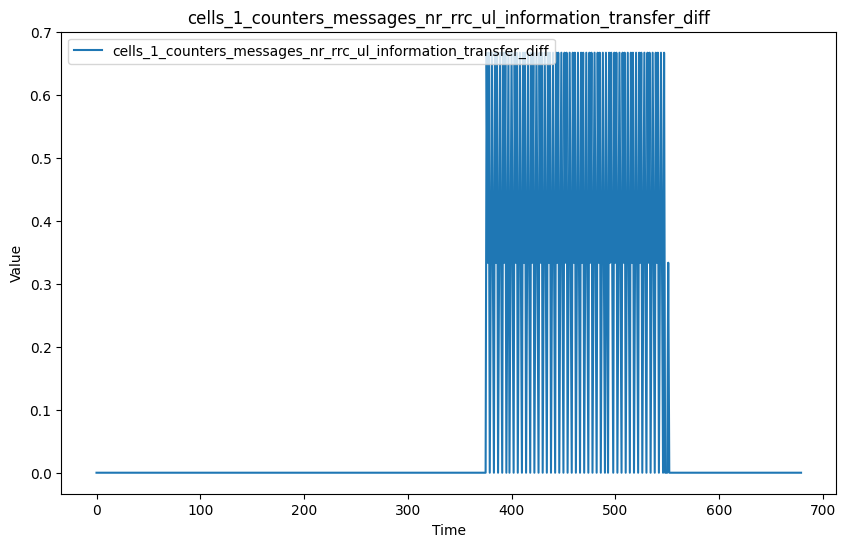

cells_1_drb_count_avg_diff


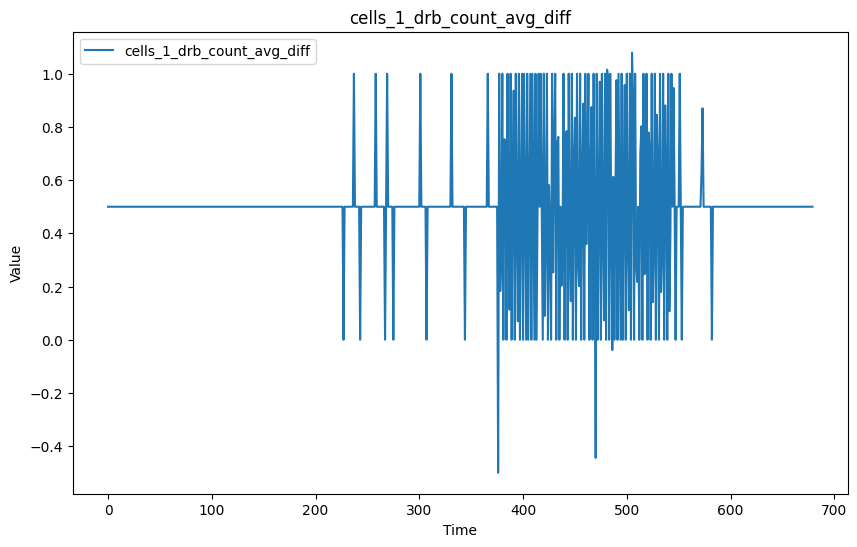

cells_1_drb_count_max_diff


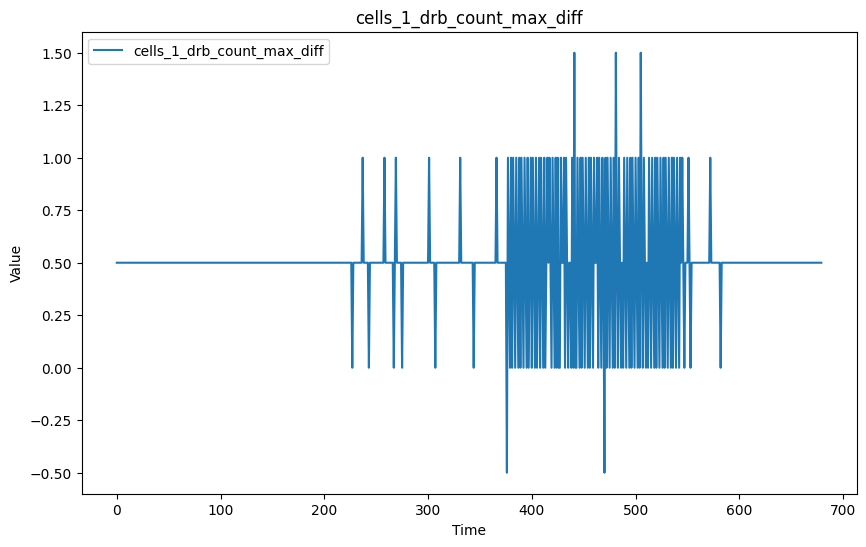

cells_1_drb_count_min_diff


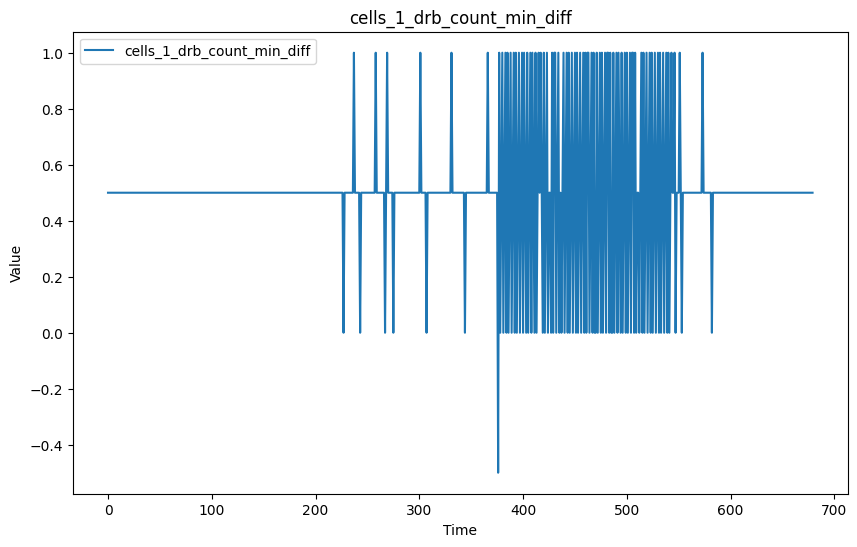

counters_messages_ng_pdu_session_resource_release_command_diff


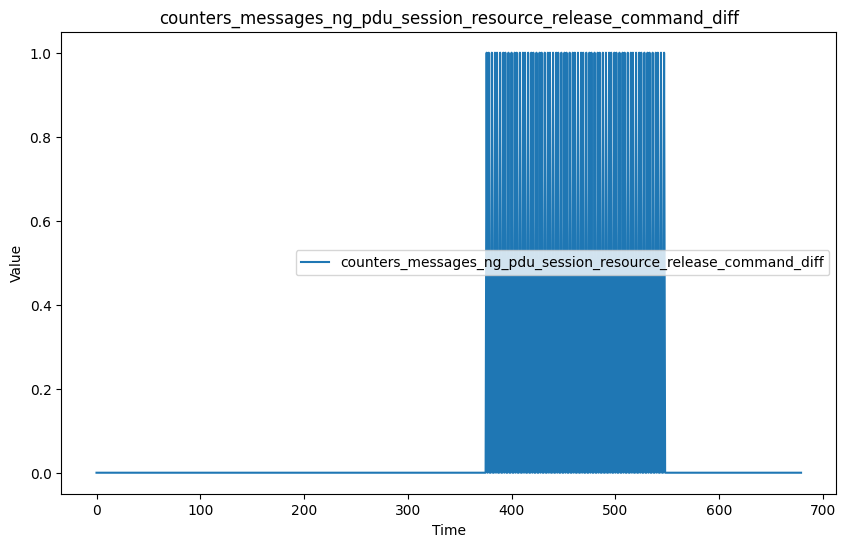

counters_messages_ng_pdu_session_resource_release_response_diff


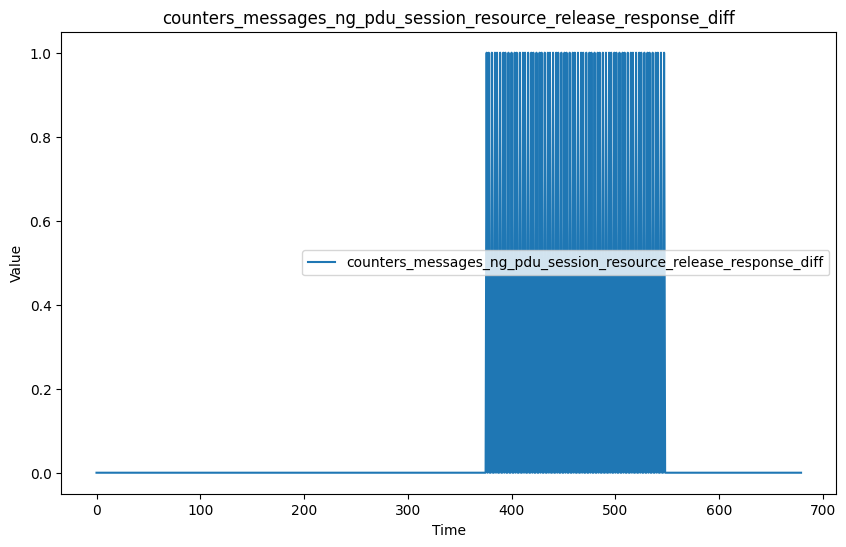

counters_messages_ng_pdu_session_resource_setup_request_diff


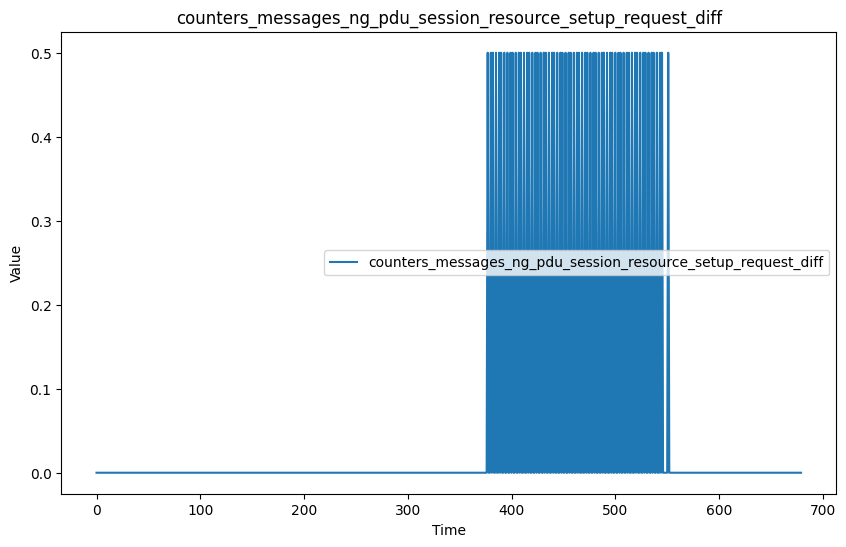

counters_messages_ng_pdu_session_resource_setup_response_diff


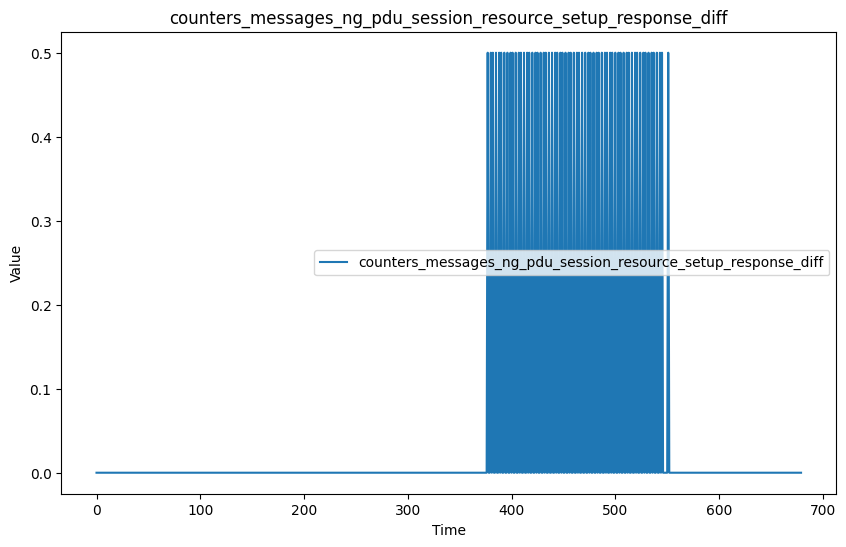

counters_messages_ng_uplink_nas_transport_diff


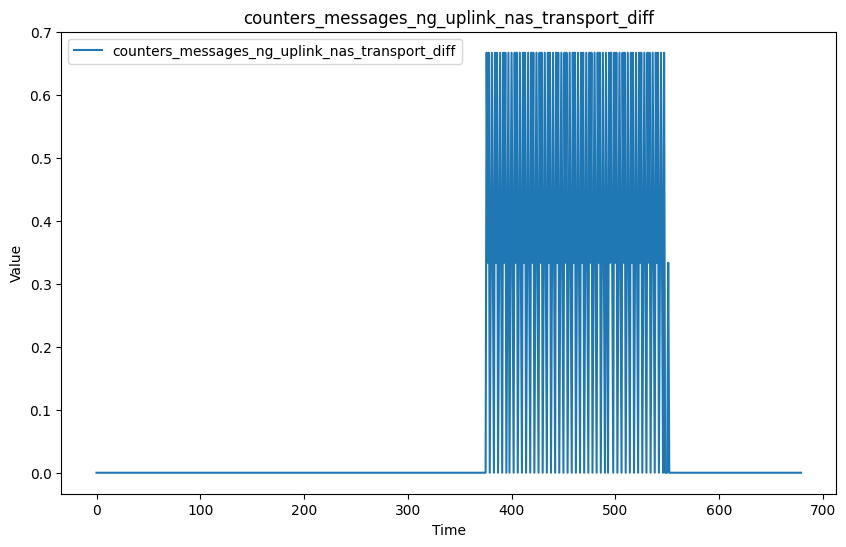

In [58]:
visualize_data(test_df)

In [59]:
from scipy.stats import t, norm
import numpy as np


# Z-score based anomaly detection
def z_score_anomaly_detection(data, threshold=3):
    z_scores = np.abs((data - data.mean()) / data.std())
    anomalies = z_scores > threshold
    return anomalies

# Median Absolute Deviation (MAD) Based Anomaly Detection
def mad_anomaly_detection(data, threshold=3):
    median = data.median()
    mad = (data - median).abs().median()
    mad_scores = (data - median).abs() / mad
    anomalies = mad_scores > threshold
    return anomalies

# Hampel Filter Based Anomaly Detection
def hampel_filter_anomaly_detection(data, window_size=5, n_sigmas=3):
    k = 1.4826 # scaling factor for Gaussian distribution
    rolling_median = data.rolling(window=window_size, center=True).median()
    MAD = k * data.rolling(window=window_size, center=True).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
    threshold = n_sigmas * MAD
    difference = np.abs(data - rolling_median)
    anomalies = difference > threshold
    return anomalies



In [60]:
def apply_anomaly_detection_method(train_df, test_df, method_func):
    # Apply the given anomaly detection method to the training and testing datasets
    train_anomalies = train_df.apply(method_func)
    test_anomalies = test_df.apply(method_func)

    return train_anomalies.any(axis=1), test_anomalies.any(axis=1)

zscore_train_anomalies, zscore_test_anomalies = apply_anomaly_detection_method(train_df, test_df, z_score_anomaly_detection)
mad_train_anomalies, mad_test_anomalies = apply_anomaly_detection_method(train_df, test_df, mad_anomaly_detection)
hampel_train_anomalies, hampel_test_anomalies = apply_anomaly_detection_method(train_df, test_df, hampel_filter_anomaly_detection)

test_df['anomaly_zscore'] = zscore_test_anomalies
test_df['anomaly_mad'] = mad_test_anomalies
test_df['anomaly_hampel'] = hampel_test_anomalies


# count values for each anomaly detection method
print("Z-score Anomalies:")
print(test_df['anomaly_zscore'].value_counts())
print("MAD Anomalies:")
print(test_df['anomaly_mad'].value_counts())
print("Hampel Filter Anomalies:")
print(test_df['anomaly_hampel'].value_counts())



Z-score Anomalies:
anomaly_zscore
False    545
True     135
Name: count, dtype: int64
MAD Anomalies:
anomaly_mad
False    498
True     182
Name: count, dtype: int64
Hampel Filter Anomalies:
anomaly_hampel
False    493
True     187
Name: count, dtype: int64


In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_anomaly_detection(df, method):
    y_true = df['anomaly']
    y_pred = df[method]
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1


train_df['anomaly'] = train_data['anomaly']
test_df['anomaly'] = test_data['anomaly']

methods = ['anomaly_zscore', 'anomaly_mad','anomaly_hampel']

print("\nTest set:")
for method in methods:
    accuracy, precision, recall, f1 = evaluate_anomaly_detection(test_df, method)
    print(f"{method.capitalize()} based anomaly detection: Accuracy = {accuracy:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, F1 Score = {f1:.2f}")


Test set:
Anomaly_zscore based anomaly detection: Accuracy = 0.94, Precision = 0.99, Recall = 0.78, F1 Score = 0.87
Anomaly_mad based anomaly detection: Accuracy = 0.96, Precision = 0.91, Recall = 0.96, F1 Score = 0.93
Anomaly_hampel based anomaly detection: Accuracy = 0.97, Precision = 0.91, Recall = 0.99, F1 Score = 0.95
